# Пытаемся вытащить и обработать максимум информации с сайта рейтинга

In [1]:
import pandas as pd
import numpy as np
# чтоб картинки рисовались в тетрадке
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 8)

from multiprocessing import Pool
import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_colwidth', 1000)

# Python 2 and 3 compatibility
# pip install future
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### Определяем все необходимые функции

In [2]:
# функция возвращает данные по конкретному турниру
# там дофига всего - команды, города, рейтинги, большинство в читаемом виде
# но вот  повопросные нормально не достать
# не зависит от самописных функций
def get_tourn(tourn_id):
    # если у нас на диске уже есть этот файл, то мы его берём
    try:
        d=d.read_json('get_tourn/'+str(tourn_id)+'.json')
    except Exception: # если его нет, то тянем с сайта
        t_url='http://rating.chgk.info/api/tournaments/'+str(tourn_id)+'/list'
        try:
            d=pd.read_json(t_url)
            # волшебная строчка - вытаскивает по api в формате json данные и пишет в датафрейм
            d.to_json('get_tourn/'+str(tourn_id)+'.json')
            # и записываем в файл на будущее
        except Exception:
            d=pd.DataFrame()
            # если нам ввели что-то неправильное, вернём пустой DataFrame
    return d

In [3]:
get_tourn(4585).head(5)
# турнир на 8 команд: 4902 545 мс
# турнир на 800 команд: 4328 900 мс

,base_name,bonus_a,bonus_b,current_name,d_bonus_a,d_bonus_b,d_diff_bonus,diff_bonus,idteam,included_in_rating,mask,position,predicted_position,questions_total,tech_rating
0,Первая сборная,0,1290,Первая сборная,2287,1290,-29,-29,4109,1,1.101110e+89,2.0,1,55,5964
1,Пользование лифтом запрещено,0,409,Пользование лифтом запрещено,0,409,146,146,4477,1,1.000000e+89,55.0,60,21,1158
2,Команда,0,108,Команда,0,108,0,0,28748,1,1.000000e+76,64.0,64,10,877
3,Слон потрогает тебя,1905,867,Лучшая ветка самарского метро,1905,867,-31,-31,37760,1,1.100010e+85,17.5,14,34,3985
4,На своей волне,0,451,На своей волне,0,451,-129,-129,39152,1,1.100100e+75,52.0,33,22,2926


In [4]:
# функция возвращает результат данной команды в данном турнире 
# в формате +1-1+0 (сыграла "в плюс", "в минус" или "в ноль") с точки зрения рейтингового прогноза
# зависит от get_tourn()
def get_team_result(tourn_id, team_id):
    gt=get_tourn(tourn_id)
    bns=gt[gt['idteam']==team_id]['diff_bonus'].values[0]
    return np.sign(bns)

In [5]:
%%time
get_team_result(4585, 55606)
# 231 ms

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 283 ms


1

In [6]:
def get_tourn_result(tourn_id):
    gt=get_tourn(tourn_id)
    gt=gt[['idteam', 'current_name', 'diff_bonus']]
    gt['tourn_id']=tourn_id
    gt['result']=np.sign(gt['diff_bonus'])
    gt.columns=['team_id', 'name', 'diff_bonus', 'tourn_id', 'result']
    return gt

In [7]:
get_tourn_result(4585).head(5)

,team_id,name,diff_bonus,tourn_id,result
0,4109,Первая сборная,-29,4585,-1
1,4477,Пользование лифтом запрещено,146,4585,1
2,28748,Команда,0,4585,0
3,37760,Лучшая ветка самарского метро,-31,4585,-1
4,39152,На своей волне,-129,4585,-1


In [8]:
# выдаёт результат относительно рейтинговых ожиданий команды на наборе турниров
def get_team_results(tourns, team_id):  # тут toutns - это массив айдищников
    rs=[]
    for tourn_id in tourns:
        rs.append(get_team_result(tourn_id, team_id))
    res=pd.DataFrame(rs, columns=['res'])
    res['tourn_id']=tourns
    res['team_id']=team_id
    return res

In [9]:
get_team_results([4585, 4739], 55606)

,res,tourn_id,team_id
0,1,4585,55606
1,1,4739,55606


In [10]:
# вытаскивае расплюсовку команды в данном турнире в ненормализованном виде
def get_team(tourn_id, team_id):
    try:
        d=d.read_json('get_team_from_tourn/'+str(tourn_id)+'-'+str(team_id)+'.json')
        # то же самое: сначала тащим с диска, потом из сети
    except Exception:
        try:  # обработка исключений на случай падения интернета, 404 и тп
            d=pd.read_json('http://rating.chgk.info/api/tournaments/'+str(tourn_id)+'/results/'+str(team_id))
            # волшебная строчка - вытаскивает по api в формате json данные и пишет в датафрейм
            # адреса других вошебных строчек: http://rating.chgk.info/index.php/api
            d.to_json('get_team_from_tourn/'+str(tourn_id)+'-'+str(team_id)+'.json')
            return d
        except Exception: 
            d=pd.DataFrame()
            return d    

In [11]:
get_team(4585, 55606)

,mask,tour
0,"[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]",1
1,"[1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]",2
2,"[1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]",3
3,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1]",4
4,"[1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0]",5
5,"[0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]",6


In [12]:
# функция, которая возвращает DatFrame строку: повопросные резульататы команды team_id в турнире tourn_id
def get_team_from_tourn(tourn_id, team_id):
    d=get_team(tourn_id, team_id)
    
    # лично меня бесит разбивка повопросных результатов по турам и ненормализованный вид таблиц из-за этого
    # в связи с этим начинаю некоторые танцы с бубном
    
    num_t=max(d['tour'])     # Зафиксировали число туров 
    num_qv=len(d['mask'][0]) # зафиксировали число вопросов в туре
    
    # TO DO: проверить, что бывает с турнирами, где в турах разное число вопросов
    
    rplus=list(d['mask'])
    # mask - это поле, в котором лежит список с ответами команды в туре 
    # в формате 1 (взяытй), 0 (не взятый), X - снятый (зачем?)
    # формат не очень удобный, но в экспоте с турниром вообще не распаршивается
    
    
    # ниже вытаскиваем из mask данные каждого вопроса и создаём для него свой столбец в DataFrame
    tt=0 # Счётчик вопроса, начинаем с 1
    s_l=[]  # Список с заголовком столбца
    r_l=[]  # Список со значением столбца
    
    for j in range(num_t):
        for i in range(num_qv):
            tt=tt+1
            r_l.append(rplus[j][i])
            s_l.append('qv'+str(tt))
    
    # Через словарь записываем всё в DataFrame. Наверняка можно сделаь проще
    res={} 
    res = {'tourn_id': tourn_id, 'team_id': team_id} # поля с парамерами команды и турнира появляются в пустом словаре
    for i in range(len(s_l)):
        res.update({s_l[i]:r_l[i]})   # в цикле добавляем по одной записи на каждый вопрос, это не должно быть долго
        
    d=pd.DataFrame([res], columns=res.keys())
    d=d.replace('X', 0)  # X - это снятый вопрос
    d=d.astype('Int64')
    return d

In [13]:
%%time
get_team_from_tourn(4585, 55606)  # 173 ms

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 205 ms


,tourn_id,team_id,qv1,qv2,qv3,qv4,qv5,qv6,qv7,qv8,qv9,qv10,qv11,qv12,qv13,qv14,qv15,qv16,qv17,qv18,qv19,qv20,qv21,qv22,qv23,qv24,qv25,qv26,qv27,qv28,qv29,qv30,qv31,qv32,qv33,qv34,qv35,qv36,qv37,qv38,qv39,qv40,qv41,qv42,qv43,qv44,qv45,qv46,qv47,qv48,qv49,qv50,qv51,qv52,qv53,qv54,qv55,qv56,qv57,qv58,qv59,qv60,qv61,qv62,qv63,qv64,qv65,qv66,qv67,qv68,qv69,qv70,qv71,qv72,qv73,qv74,qv75,qv76,qv77,qv78,qv79,qv80,qv81,qv82,qv83,qv84,qv85,qv86,qv87,qv88,qv89,qv90
0,4585,55606,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,1,0,0,0,1,1,1,1,1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0


In [14]:
# функция выводит расплюсовку всех команд турнира
# функция дублирует поле mask в параметрах турнира, но его нельзя корректно загрузить в pandas
# для работы нужны get_tourn() и get_team_from_tourn()
def get_tourn_plus(tourn_id):
    # Достаём список команд из одного API, а расплюсовку - из другого, в цикле по командам, потом клеим
    try:
        r=pd.read_csv('get_tourn_plus/'+str(tourn_id)+'.csv')
        # то же самое: сначала тащим с диска, потом из сети
        
        del r['Unnamed: 0']
        return r 
    except Exception:
        teams_list=list(get_tourn(tourn_id)['idteam']) # всё, что нам сейчас нужно - список команд

        r=pd.DataFrame()
        for i in range(len(teams_list)):
            b=get_team_from_tourn(tourn_id, teams_list[i])
            # описание этой функции выше
            r=pd.concat([r,b])
        r=r.astype('Int64') # иначе будет строка и когда начнём сумму считать будет сюрприз
        r=r.replace('X', 0) # X - это снятый вопрос
        #r.to_json('get_tourn_plus/'+str(tourn_id)+'.json')
        r.to_csv('get_tourn_plus/'+str(tourn_id)+'.csv')
        return r
# TO DO: откуда тут строка с нулями? - от хренового экспорта в csv. как фиксить - непонятно

In [15]:
%%time
get_tourn_plus(4585).head(5)
#(4328) 
#(4902)
# турнир на 8 команд: 2s
# турнир на 800 команд: 2 min 25s
# повторный на 800 команд: 16ms

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 83.7 ms


,tourn_id,team_id,qv1,qv2,qv3,qv4,qv5,qv6,qv7,qv8,qv9,qv10,qv11,qv12,qv13,qv14,qv15,qv16,qv17,qv18,qv19,qv20,qv21,qv22,qv23,qv24,qv25,qv26,qv27,qv28,qv29,qv30,qv31,qv32,qv33,qv34,qv35,qv36,qv37,qv38,qv39,qv40,qv41,qv42,qv43,qv44,qv45,qv46,qv47,qv48,qv49,qv50,qv51,qv52,qv53,qv54,qv55,qv56,qv57,qv58,qv59,qv60,qv61,qv62,qv63,qv64,qv65,qv66,qv67,qv68,qv69,qv70,qv71,qv72,qv73,qv74,qv75,qv76,qv77,qv78,qv79,qv80,qv81,qv82,qv83,qv84,qv85,qv86,qv87,qv88,qv89,qv90
0,4585,4109,1,1,0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,1,1,0,0,1,0,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,1
1,4585,4477,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0
2,4585,28748,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,4585,37760,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,1,1,0,1,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0,0
4,4585,39152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0


In [16]:
# функция вывод поповпросные резульатты лучших top команд выбранного турнира
# для работы нужна get_tourn_plus()
def get_team_top(tourn_id, top):
    # подкинем результат для лучших н команд
    
    df=get_tourn_plus(tourn_id)
    
    tp=df  # временный даатфрейм для извращений

    trb=tp['tourn_id']
    tmd=tp['team_id']  # сначала сохраняем в буфер стобцы с командами и турниром

    del tp['tourn_id'] # потом убиваем их
    del tp['team_id']

    tp['sum']=tp.sum(axis=1)  # вот можно посчитать сумму по строке, вы знали?

    tp['tourn_id']=trb  # возвращаем блудные idшники
    tp['team_id']=tmd

    tp=tp.sort_values(by='sum',  ascending=False) # сортиуем по взятым
    
    return tp[0:top] # берём только топ
    

In [17]:
%%time
get_team_top(4585, 5)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 26 ms


,qv1,qv2,qv3,qv4,qv5,qv6,qv7,qv8,qv9,qv10,qv11,qv12,qv13,qv14,qv15,qv16,qv17,qv18,qv19,qv20,qv21,qv22,qv23,qv24,qv25,qv26,qv27,qv28,qv29,qv30,qv31,qv32,qv33,qv34,qv35,qv36,qv37,qv38,qv39,qv40,qv41,qv42,qv43,qv44,qv45,qv46,qv47,qv48,qv49,qv50,qv51,qv52,qv53,qv54,qv55,qv56,qv57,qv58,qv59,qv60,qv61,qv62,qv63,qv64,qv65,qv66,qv67,qv68,qv69,qv70,qv71,qv72,qv73,qv74,qv75,qv76,qv77,qv78,qv79,qv80,qv81,qv82,qv83,qv84,qv85,qv86,qv87,qv88,qv89,qv90,sum,tourn_id,team_id
38,1,1,1,1,1,0,0,1,1,0,1,0,0,1,1,1,0,0,1,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,0,1,1,1,1,0,0,1,1,1,1,0,1,1,57,4585,55517
0,1,1,0,1,1,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,1,1,0,0,1,0,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,1,1,1,0,1,0,1,0,0,1,1,0,1,1,1,1,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,1,55,4585,4109
48,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,1,1,1,0,0,1,0,1,1,1,0,0,1,1,0,1,0,1,1,0,1,1,0,43,4585,59419
16,1,0,0,0,0,0,0,1,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,1,0,1,0,42,4585,46916
44,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,1,1,1,0,1,0,0,0,1,0,0,1,1,1,0,1,1,0,1,1,1,1,0,1,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,1,1,0,1,1,42,4585,55655


In [18]:
# функция для расчёта рейтинга и сложности вопросов
# кроме того, функция пытается разбить вопросы на классы сложности
# для работы нужны get_tourn_plus() и пакет для работы kmeans
def tourn_dif(tourn_id):
    # рейтинг взятых вопросов здесь и ниже считается немного необычно: как доля невзятых вопросов
    # обычно на турнирах нормировкой рейтинга не занимаются, 
    # но на нужно будет сравнивать сложность вопросов разных турниров
    
    df=get_tourn_plus(tourn_id) # вытащили расплюсовку конкретного турнира
    # описание этой функции выше

    df=df.replace('X', 0)  # ставим нолики вместо снятых
    
    g1 = df.groupby(['tourn_id']).agg('sum')
    # группировка по числу взятых
    g2 = df.groupby(['tourn_id']).agg('count')
    # группировка по общей сумме, заложились на случай туринров по системе микроматчей
    
    g=pd.concat([g1,g2])
    # да-да, скажите мне, что это неизящно
    
    g=g.reset_index()
    # возможный источник проблем
    
    
    
    # ниже будут совсем неочевидные решения, возможно, тут надо всё переделать
    gtmp=g
    del gtmp['tourn_id']
    del gtmp['team_id']
    # после удаления id в датафрейме только вопросы и показатели числа взятых
    
    v=g.transpose()
    
    v.columns = ['sum', 'total']
    v['share']=1-(v['sum']/v['total'])  # это и есть сложность, чем больше, тем вопрос сложнее
    
    v['qv_num']=range(1,len(v['share'])+1)
    # номер вопроса отдельным понял понадобился для будущей сортировке и из-за транспонирования
    #v['share'].plot() график вполне познавательный
    
    ###
    # возможно, тут функцию стоит закончить, мы получили нужные нам метрики
    ###
    
    v=v.sort_values(by='share', ascending=True)
    # сортировка в порядке убывания сложности
    # по идее она не должна влиять на результат кластеризации, хотя кто его знает
    
    # дальше мы с помощью стандартного K-means пытаемся разбить вопросы на классы сложности
    X=v[['total', 'share']].values  # бахнули число вопросов, так как стандартный интерфейс K-means двумерный
    kmeans = KMeans(n_clusters=4, random_state=0).fit(X)  # 4 кластера - не догма, но выглядит разумно
    
    v['label']=(kmeans.labels_)
    v['class']=(kmeans.labels_)/max(kmeans.labels_) 
    # нормировка лейблов: 
    # во-первых, графики на одной оси,
    # во-вторых в случае изменения числа кластеров у старшего всё равно будет 1 
    
    #v[['class', 'share']].plot()
    # важный график
    v=v.replace('X', 0)
    
    # считаем среднюю сложность по группам вопросов
    g=pd.DataFrame(v.groupby(['label', 'class'])['share'].mean())
    g=g.reset_index()
    g.columns=['label', 'class', 'class_chare']
    
    v=v.merge(g, left_on=['class', 'label'], right_on=['class', 'label'], how='outer')
    
    v=v.sort_values(by='qv_num', ascending=True)
    # над правильной сортировкой надо подумать
    
    return v

In [19]:
tourn_dif(4585).head(5)

,sum,total,share,qv_num,label,class,class_chare
32,25,64,0.609375,1,3,1.000000,0.539062
40,19,64,0.703125,2,0,0.000000,0.739375
50,15,64,0.765625,3,0,0.000000,0.739375
60,11,64,0.828125,4,2,0.666667,0.903730
62,10,64,0.843750,5,2,0.666667,0.903730


In [20]:
# функция, которая возвращает рейтиг команды на турнире
# для работы нужны get_team_from_tourn() и =tourn_dif()
def get_team_rating(tourn_id, team_id):
    # Рейтинг команды - это сумма рейтинга вопросов, которые она взяла
    # Тянем рейтинги вопросов, тянет повопросник команды, конвертируем в списки и сумма произведений
    
    # пока не работает корректно
    
    tm=get_team_from_tourn(tourn_id, team_id)
    # тянем повопросные команды, описание этой функции выше
    
    tm=tm.astype('Int64')
    
    del tm['tourn_id']
    del tm['team_id']
    # теперь ничего лишнего
    
    t_p=list(tm.values[0])
    # конвертируем в список
    
    trn=tourn_dif(tourn_id)
    # тянем сложность вопросов турниров, описание этой функции выше
    
    trn=trn.sort_values(by='qv_num')
    # тут сортировка по номеру вопроса очень важна
    
    trn=trn.transpose()
    sh=list(trn.loc['share'].astype('float'))
    # конвертируем в список
    
    # стандартная вещь из NumPy почему-то не хочет работать с float
    # ну и чёрт с ним, пишем сумму произведений вручную, это не должно быть долго
    s=0
    for i in range(len(t_p)):
        s=s+sh[i]*t_p[i]
    return s

In [21]:
get_team_rating(4585, 55606)

23.640625

In [22]:
# вспомогательная функция, выводит результат топа команд по категориям сложности
# для работы нужны get_team_top()
def get_top_dif(tourn_id):
    top=20
    tm=get_team_top(tourn_id, top)
    if len(tm)<20: 
        top=3
        tm=get_team_top(tourn_id, top)


    del tm['tourn_id']
    del tm['team_id']  # режем ненужное
    del tm['sum']

    tm=tm.transpose()

    st=[]
    qv_n=[]
    for i in range (1,top+1):
        st.append('t_'+str(i))

    tm.columns=st
    tm['t_dif']=tm.sum(axis=1)/top


    tm['qv_num']=range(1,len(tm['t_dif'])+1)
    tm=tm[['qv_num', 't_dif']]


    td=tourn_dif(tourn_id)
    td=td.merge(tm, left_on=['qv_num'], right_on=['qv_num'], how='outer')

    
    return td

In [23]:
get_top_dif(4585).head(5)

,sum,total,share,qv_num,label,class,class_chare,t_dif
0,25,64,0.609375,1,3,1.000000,0.539062,0.60
1,19,64,0.703125,2,0,0.000000,0.739375,0.40
2,15,64,0.765625,3,0,0.000000,0.739375,0.35
3,11,64,0.828125,4,2,0.666667,0.903730,0.25
4,10,64,0.843750,5,2,0.666667,0.903730,0.40


In [24]:
# функция для определенимя результата команды в зависимости от категорий сложности вопросов
# для работы нужнры get_team_from_tourn(), tourn_dif()
def team_tourn_cat_dif(tourn_id, team_id):
    tm=get_team_from_tourn(tourn_id, team_id)
    # загрузили результат команды
    
    del tm['tourn_id']
    del tm['team_id']  # режем ненужное
    tm=tm.transpose()
    
    df=get_top_dif(tourn_id)

    # берём турнир
    df['team']=tm.values  # теперь в датафрейме турнира есть стобец команды
    df['team']=df['team'].astype('Int64')
    
    g1=pd.DataFrame(df.groupby(['class'])['team'].sum())
    g2=pd.DataFrame(df.groupby(['class'])['team'].agg('count'))
    g3=pd.DataFrame(df.groupby(['class'])['share'].agg('mean'))
    g4=pd.DataFrame(df.groupby(['class'])['t_dif'].agg('mean'))
    # сгруппировали интеерсующие нас метрики
    
    g=pd.concat([g1,g2, g3, g4], axis=1)
    g=g.reset_index()
    
    g.columns=['class', 'plus', 'total', 'dif', 'top']
    g['team_share']=g['plus']/g['total']
    # посчитали долю взятых на классе
    
    g['avg_share']=1-g['dif']
    
    g=g.sort_values(by='dif')
    
    g['mark']=np.where(g['team_share'] >=g['top'], 2, np.where(g['team_share'] >=g['avg_share'], 1, 0))
    
    #g=g.reset_index()
    
    # осортировали классы по сложности турнира
    return g

In [25]:
team_tourn_cat_dif(4585, 55606).head(5)

,class,plus,total,dif,top,team_share,avg_share,mark
1,0.333333,14,16,0.297852,0.809375,0.875000,0.702148,2
3,1.000000,9,18,0.539062,0.641667,0.500000,0.460938,1
0,0.000000,12,25,0.739375,0.396000,0.480000,0.260625,2
2,0.666667,7,31,0.903730,0.170968,0.225806,0.096270,2


In [26]:
def show_tourn_dist(tourn_id):
    v=tourn_dif(tourn_id)
    
    v=v.sort_values(by='qv_num', ascending=True)
    
    with plt.xkcd():
        plt.title('Tourn '+str(tourn_id))
        plt.xlabel('Number_of_qv')
        plt.ylabel('Qv_difficulty')
        plt.plot(v['qv_num'], v['share'])

        #v=v.sort_values(by='share', ascending=True)

        #v[['class', 'share']].plot(kind='area')

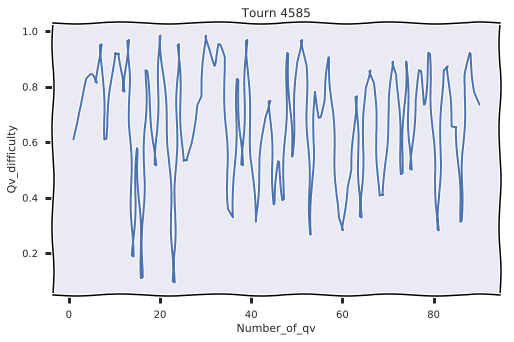

In [27]:
show_tourn_dist(4585)

In [28]:
def team_mark(tourn_id, team_id):
    df=team_tourn_cat_dif(tourn_id, team_id)
    df=df.sort_values(by='dif')
    df=df.set_index('dif')
    if df['plus'].sum()<6:
        res='weak'
    elif ((df['mark'].values[0]+df['mark'].values[1])) > ((df['mark'].values[2]+df['mark'].values[3])):
        res='tech'
    elif ((df['mark'].values[0]+df['mark'].values[1])) < ((df['mark'].values[2]+df['mark'].values[3])):
        res='creat'
    elif (df['mark'].values[0]==df['mark'].values[1]) and (df['mark'].values[1]==df['mark'].values[2]) and (df['mark'].values[2]==df['mark'].values[3]):
        res='stab'
    else:
        res='unst'
    return res

In [29]:
team_mark(4585, 55606)

'creat'

In [30]:
def tourn_mark(tourn_id):
    try:
        df=pd.read_csv('tourn_mark/'+str(tourn_id)+'.csv')
    except Exception: 
        t_l=[]
        teams_list=list(get_tourn(tourn_id)['idteam'])
        teams_names=list(get_tourn(tourn_id)['current_name'])

        i=0
        for i in range(len(teams_list)):
            t_l.append(team_mark(tourn_id, teams_list[i]))
        df=pd.DataFrame(t_l)

        df.columns=['type']
        df['team_id']=1
        df['team_id']=teams_list
        df['current_name']=teams_names
        df.to_csv('tourn_mark/'+str(tourn_id)+'.csv')
    return df

In [31]:
%%time
tourn_mark(4585).head(5)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 49.3 ms


,Unnamed: 0,type,team_id,current_name
0,0,stab,4109,Первая сборная
1,1,stab,4477,Пользование лифтом запрещено
2,2,stab,28748,Команда
3,3,creat,37760,Лучшая ветка самарского метро
4,4,stab,39152,На своей волне


In [32]:
def show_tourn_lev(tourn_id):
    v=tourn_dif(tourn_id)
    with plt.xkcd():
    
        v=v.sort_values(by='share', ascending=True)
        p=v[['qv_num', 'class', 'share']]
        plt.xlabel('Questions')
        plt.ylabel('difficulty')

        plt.plot(range(len(p['share'])), p['share'])

        
        plt.show()

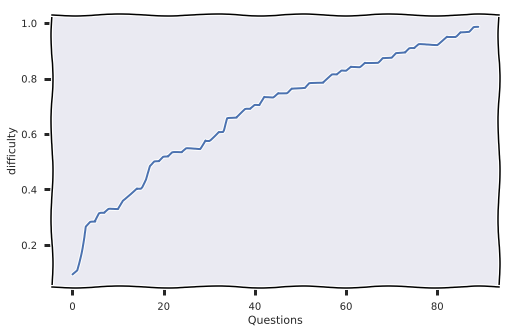

In [33]:
show_tourn_lev(4585)

In [34]:
def show_tourn_levl(tourn):
    v=[]
    for i in range(len(tourn)):
        v.append(tourn_dif(tourn[i]))
        
    for i in range(len(tourn)):
        with plt.xkcd():
            v[i]=v[i].sort_values(by='share', ascending=True)
            plt.xlabel('Questions')
            plt.ylabel('difficulty')
            

            plt.plot(range(len(v[i]['share'])), v[i]['share'], label=tourn[i])

    plt.legend()
    plt.show()

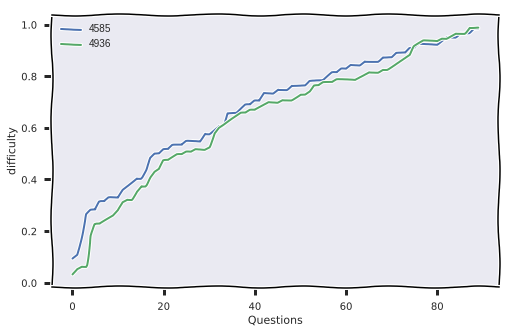

In [35]:
show_tourn_levl([4585, 4936])

### Тесты и проверки

In [36]:
%%time
# команда для измерения времени на все эти запросы

# тесты
tourn_id=4810
#tourn_id=61160
team_id=61160

#тестовый набор - Постпанк на студчр

df=get_tourn_plus(tourn_id)
df=get_tourn(tourn_id)
df=get_team_from_tourn(tourn_id, team_id)
df=tourn_dif(tourn_id)

#df=team_tourn_cat_dif(tourn_id, team_id)
#df=get_top_dif(tourn_id)
#df=get_team_rating(tourn_id, team_id)

#df=team_tourn_cat_dif(tourn_id, team_id)

# Для очника 
# get_tourn_plus 12 секунд
# get_tourn 0.2 секундs
# get_tourn_plus 0.2 секунды
# tourn_dif 13 секунд

# синхроны будут дольше, до 2 минут

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 690 ms


In [37]:
# автотесты по турниру, который считался вручную
print(get_team_rating(4651, 61160))   
# должно быть 16.62
print(get_team_rating(4651, 50707))
# должно быть 16.05
print(get_team_rating(4651, 55606))
# должно быть 14.85

16.6153846154
16.0512820513
14.8461538462


In [38]:
team_id=59814  # хотята
t1=4369 # шестой овощ
t2=4739 # кубок физтеха
t3=4577 # игры первопрестольной


In [39]:
%%time
team_tourn_cat_dif(t1, team_id)

CPU times: user 184 ms, sys: 4 ms, total: 188 ms
Wall time: 379 ms


,class,plus,total,dif,top,team_share,avg_share,mark
0,0.000000,5,5,0.260023,1.000000,1.000000,0.739977,2
2,0.666667,5,8,0.473916,0.931250,0.625000,0.526084,1
1,0.333333,4,11,0.708835,0.795455,0.363636,0.291165,1
3,1.000000,2,12,0.843200,0.704167,0.166667,0.156800,1


In [40]:
%%time
team_tourn_cat_dif(4193, 40195)

CPU times: user 200 ms, sys: 4 ms, total: 204 ms
Wall time: 815 ms


,class,plus,total,dif,top,team_share,avg_share,mark
1,0.333333,7,7,0.101732,0.971429,1.000000,0.898268,2
3,1.000000,13,16,0.366477,0.793750,0.812500,0.633523,2
0,0.000000,14,25,0.666061,0.458000,0.560000,0.333939,2
2,0.666667,7,42,0.900433,0.190476,0.166667,0.099567,1


In [41]:
%%time
team_tourn_cat_dif(3973, 55606)

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 341 ms


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,13,15,0.214444,0.933333,0.866667,0.785556,1
1,0.333333,6,10,0.480000,0.820000,0.600000,0.520000,1
3,1.000000,5,12,0.697222,0.491667,0.416667,0.302778,1
0,0.000000,2,11,0.913636,0.159091,0.181818,0.086364,2


In [42]:
a=team_tourn_cat_dif(t3, team_id)

In [43]:
m=[4292,
4472,
4739]
for i in range(3):
    print(team_mark(m[i], 59814))

tech
tech
creat


In [44]:
dd=pd.DataFrame(m)
aa=dd.iloc[0].value_counts()

In [45]:
dd.iloc[0]

0    4292
Name: 0, dtype: int64

In [46]:
aa

4292    1
Name: 0, dtype: int64

### Первые исследования

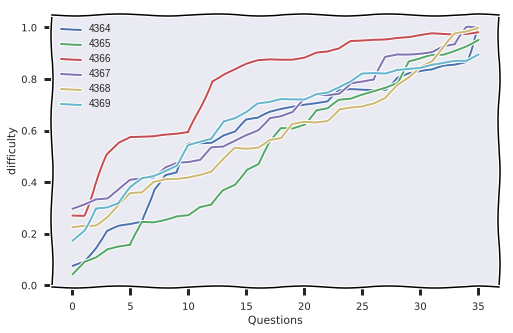

CPU times: user 2.04 s, sys: 12 ms, total: 2.05 s
Wall time: 2.33 s


In [47]:
%%time
# Сложность овсч этого сезона, наложенная друг на друга
ov=[4364,
4365,
4366,
4367,
4368,
4369]
show_tourn_levl(ov)

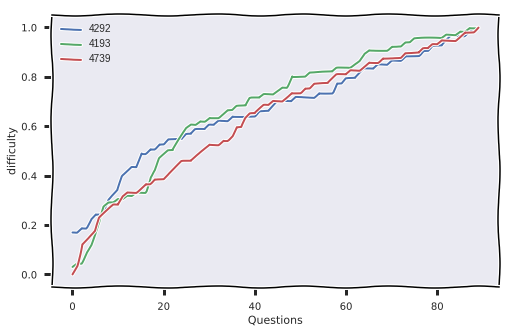

CPU times: user 1.51 s, sys: 24 ms, total: 1.53 s
Wall time: 1.95 s


In [48]:
%%time
# Сложность очников-90, наложенная друг на друга
m1=[4292, # мгимо
4193, # студчр
4739]  # физтех
show_tourn_levl(m1)

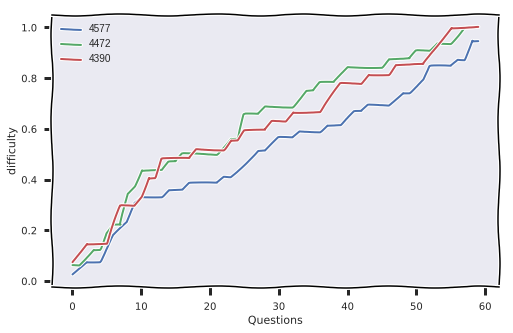

CPU times: user 1.55 s, sys: 12 ms, total: 1.56 s
Wall time: 1.83 s


In [49]:
%%time
# Сложность очников-60, наложенная друг на друга
m2=[4577, # первопрестольная
4472, # СККО
4390]  # ярославль
show_tourn_levl(m2)

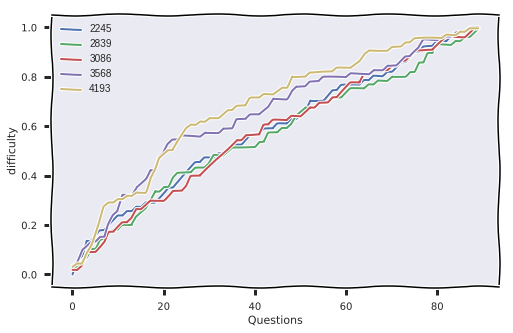

CPU times: user 1.75 s, sys: 12 ms, total: 1.76 s
Wall time: 1.94 s


In [50]:
%%time
# Эволюция студчр
r=[2245,
2839,
3086,
3568,
4193]
show_tourn_levl(r)

### Детальный анализ одного турнира

Межфакультетский кубок МГУ-2018

In [51]:
get_tourn(4872).head(5)

,base_name,bonus_a,bonus_b,current_name,d_bonus_a,d_bonus_b,d_diff_bonus,diff_bonus,idteam,included_in_rating,mask,position,predicted_position,questions_total,tech_rating
0,Прочерк,1568,771,Прочерк,1568,771,273,273,2823,1,1.110110e+32,11.5,14.0,16,2139
1,Механизм реакции,2254,1413,Механизм реакции,2254,1413,499,499,3133,0,1.111100e+35,2.0,9.0,25,4055
2,Пользование лифтом запрещено,0,113,Служба подавления восстания машин,0,113,-86,-86,4477,1,1.100010e+32,37.0,28.0,8,1193
3,Армия МурАвьев,0,352,Армия МурАвьев,152,352,160,160,27280,1,1.011001e+34,23.0,37.0,13,537
4,Пророк ИСАиА,0,1147,Пророк ИСАиА,1941,1147,281,281,39057,0,1.111001e+34,6.0,10.0,20,3790


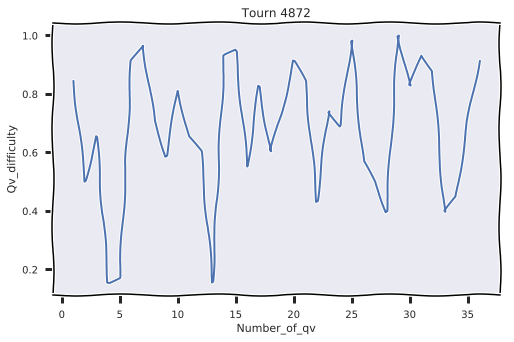

In [52]:
show_tourn_dist(4872)

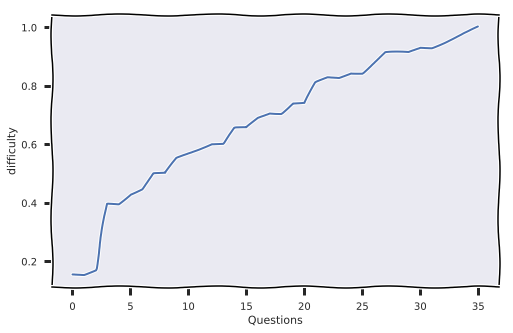

In [53]:
show_tourn_lev(4872)


In [54]:
tourn_mark(4872)

,Unnamed: 0,type,team_id,current_name
0,0,creat,2823,Прочерк
1,1,stab,3133,Механизм реакции
2,2,tech,4477,Служба подавления восстания машин
3,3,tech,27280,Армия МурАвьев
4,4,stab,39057,Пророк ИСАиА
5,5,tech,41956,Абажур Ожегова
6,6,tech,41970,Up
7,7,creat,43001,Солнечный круг
8,8,stab,44196,Doing a Bradbury
9,9,stab,44198,Интеграл с разбега


In [55]:
# DaB
print(team_mark(4872, 44196))
team_tourn_cat_dif(4872, 44196)

stab


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,3,3,0.160920,0.966667,1.000000,0.839080,2
3,1.000000,6,7,0.460591,0.800000,0.857143,0.539409,2
1,0.333333,10,11,0.659875,0.609091,0.909091,0.340125,2
0,0.000000,6,15,0.902299,0.193333,0.400000,0.097701,2


In [56]:
# Восточный экспресс
print(team_mark(4872, 50949))
team_tourn_cat_dif(4872, 50949)

stab


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,2,3,0.160920,0.966667,0.666667,0.839080,0
3,1.000000,3,7,0.460591,0.800000,0.428571,0.539409,0
1,0.333333,1,11,0.659875,0.609091,0.090909,0.340125,0
0,0.000000,0,15,0.902299,0.193333,0.000000,0.097701,0


In [57]:
# Восточный экспресс
print(team_mark(4872, 58237))
team_tourn_cat_dif(4872, 58237)

weak


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,2,3,0.160920,0.966667,0.666667,0.839080,0
3,1.000000,1,7,0.460591,0.800000,0.142857,0.539409,0
1,0.333333,1,11,0.659875,0.609091,0.090909,0.340125,0
0,0.000000,0,15,0.902299,0.193333,0.000000,0.097701,0


In [58]:
# Прочерк
print(team_mark(4872, 2823))
team_tourn_cat_dif(4872, 2823)

creat


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,3,3,0.160920,0.966667,1.000000,0.839080,2
3,1.000000,3,7,0.460591,0.800000,0.428571,0.539409,0
1,0.333333,8,11,0.659875,0.609091,0.727273,0.340125,2
0,0.000000,2,15,0.902299,0.193333,0.133333,0.097701,1


In [59]:
# Р
print(team_mark(4872, 55555))
team_tourn_cat_dif(4872, 55555)

creat


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,2,3,0.160920,0.966667,0.666667,0.839080,0
3,1.000000,2,7,0.460591,0.800000,0.285714,0.539409,0
1,0.333333,4,11,0.659875,0.609091,0.363636,0.340125,1
0,0.000000,2,15,0.902299,0.193333,0.133333,0.097701,1


In [60]:
# Армия муравьев
print(team_mark(4872, 27280))
team_tourn_cat_dif(4872, 27280)

tech


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,3,3,0.160920,0.966667,1.000000,0.839080,2
3,1.000000,5,7,0.460591,0.800000,0.714286,0.539409,1
1,0.333333,3,11,0.659875,0.609091,0.272727,0.340125,0
0,0.000000,2,15,0.902299,0.193333,0.133333,0.097701,1


In [61]:
# Бублик от дырки
print(team_mark(4872, 44204))
team_tourn_cat_dif(4872, 44204)

tech


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,3,3,0.160920,0.966667,1.000000,0.839080,2
3,1.000000,5,7,0.460591,0.800000,0.714286,0.539409,1
1,0.333333,5,11,0.659875,0.609091,0.454545,0.340125,1
0,0.000000,1,15,0.902299,0.193333,0.066667,0.097701,0


In [62]:
# Бублик от дырки
print(team_mark(4872, 58359))
team_tourn_cat_dif(4872, 58359)

unst


,class,plus,total,dif,top,team_share,avg_share,mark
2,0.666667,3,3,0.160920,0.966667,1.000000,0.839080,2
3,1.000000,5,7,0.460591,0.800000,0.714286,0.539409,1
1,0.333333,6,11,0.659875,0.609091,0.545455,0.340125,1
0,0.000000,5,15,0.902299,0.193333,0.333333,0.097701,2


День физика

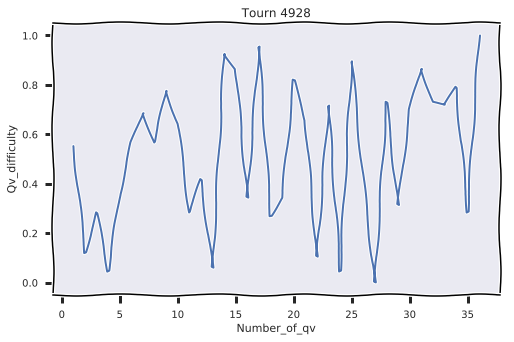

In [63]:
show_tourn_dist(4928)

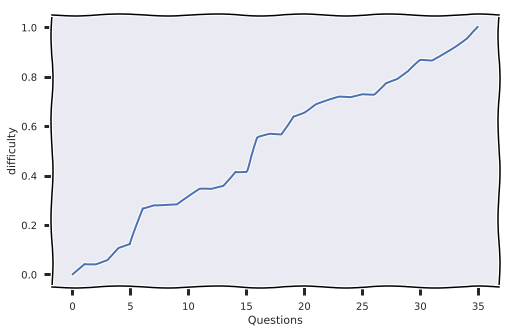

In [64]:
show_tourn_lev(4928)

In [65]:
tourn_dif(4928)

,sum,total,share,qv_num,label,class,class_chare
16,30,67,0.552239,1,2,0.666667,0.660787
5,59,67,0.119403,2,3,1.000000,0.062189
7,48,67,0.283582,3,1,0.333333,0.331343
1,64,67,0.044776,4,3,1.000000,0.062189
13,43,67,0.358209,5,1,0.333333,0.331343
18,29,67,0.567164,6,2,0.666667,0.660787
21,21,67,0.686567,7,2,0.666667,0.660787
17,29,67,0.567164,8,2,0.666667,0.660787
27,15,67,0.776119,9,0,0.000000,0.877280
19,24,67,0.641791,10,2,0.666667,0.660787


ОКР-2017

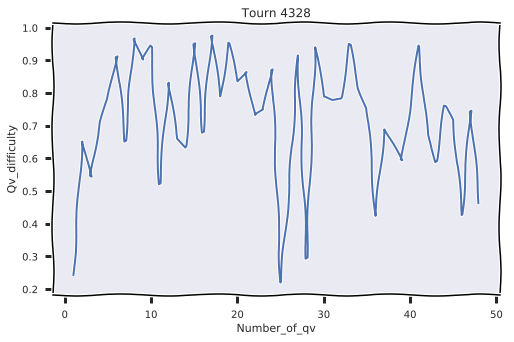

In [92]:
show_tourn_dist(4328)

In [100]:
# 
print(team_mark(4328, 49804))
team_tourn_cat_dif(4328, 49804)

stab


,class,plus,total,dif,top,team_share,avg_share,mark
3,1.000000,3,3,0.252073,1.000000,1.000000,0.747927,2
1,0.333333,8,8,0.508862,0.950000,1.000000,0.491138,2
2,0.666667,20,22,0.725351,0.759091,0.909091,0.274649,2
0,0.000000,8,15,0.917828,0.320000,0.533333,0.082172,2


In [98]:
# Химера
print(team_mark(4328, 1470))
team_tourn_cat_dif(4328, 1470)

creat


,class,plus,total,dif,top,team_share,avg_share,mark
3,1.000000,2,3,0.252073,1.000000,0.666667,0.747927,0
1,0.333333,6,8,0.508862,0.950000,0.750000,0.491138,1
2,0.666667,10,22,0.725351,0.759091,0.454545,0.274649,1
0,0.000000,2,15,0.917828,0.320000,0.133333,0.082172,1


In [91]:
#ОКР-2017
tourn_mark(4328)

,type,team_id,current_name
0,tech,23,16 тонн
1,tech,58,Anno Domini
2,tech,63,В-Ч-Ж
3,tech,66,Ультиматум
4,tech,79,Старики-разбойники
5,tech,84,Норманны
6,creat,101,Славяне
7,unst,137,Феникс
8,tech,153,Едва
9,unst,157,Дети Патанджали


## Результаты категорий команд на наборе турниров

### Определяем группы турниров

In [130]:
es=[4488, 4497]  # простые синхроны: Школьный лайт, Лига Сибири
eo=[4887, 4978]  # простые очники: Чемпионат Финляндии, Мозгорейтинг
hs=[4671, 4693]  # сложные синхроны: Король-Мерзляков, Посошок Аарончика
ho=[2764, 4936]  # сложные очники: Одинадцатый блин, Чемпионат России

schr=[2245,
2839,
3086,
3568,
4193]  # чемпионаты России срежди студентов

ov=[4364,
4365,
4366,
4367,
4368,
4369]  # овсч


m=[4292, # мгимо
4193, # студчр
4739, # физтех
4577, # первопрестольная
4472, # СККО
4390]  # ярославль

easy=[  #сложность меньше, чем 2000
4890,
4684,
4486,
4987,
4871,
4700,
4543,
4892,
4920,
4715,
4645,
4490,
4838,
4487,
4470,
4651,
4897,
4725,
4908,
4945,
4458,
4694,
4537,
4978,
4668,
4752,
4633,
4497,
4907,
4488,
4771,
4496,
4766,
4536,
4789,
4412,
4495,
4539,
4631,
4538,
4599,
4582,
4596,
4878,
4901,
4629,
4343,
4632,
4337,
4810,
4475,
4499,
4613,
4769,
4656,
4563,
4529,
4748,
4474,
4534,
4557,
4349,
4309,
4737,
4567,
4200,
4812,
4660,
4471,
4887,
4824,
4940,
4530,
4662,
4669,
4466,
4926,
4729,
4413,
4574,
4365,
4817,
4555,
4647,
4484,
4558,
4540,
4385,
4865,
4726,
4605,
4637,
4368,
4640,
4607,
4820,
4541,
4744,
4500,
4831,
4883,
4925,
4611,
4554,
4362,
4364,
4815,
4682,
4761,
4928,
4642,
4773,
4770,
4581,
4556,
4159,
4899,
4818,
4683,
4659,
4492,
4133,
4886,
4331,
4717,
4688,
4806,
4292,
4545,
4587,
4602,
4749,
4807,
4390,
4459,
4489,
4932,
4367,
4608,
4858,
4745,
4525,
4823,
4713,
4533,
4808,
4580,
4741,
4663,
4844,
4711,
4900,
4334,
4777,
4676,
4853,
4311,
4958,
4430,
4493,
4639,
4494,
4704,
4516,
4150,
4736,
4303,
4894,
4730,
4654,
4477,
4535,
4782,
4404,
4369,
4572,
4332,
4552,
4522,
4601,
4480,
4905,
4915,
4783,
4792,
4681,
4813,
4260,
4598,
4559,
4472,
4504,
4526,
4481,
4857,
4746,
4778,
4882,
4483,
4691,
4856,
4885,
4799,
4674,
4738,
4904,
4739,
4819,
5022,
4743,
4511,
4594,
4702,
4827,
4911,
4859,
4517,
4521,
4595,
4941,
4610,
4531,
4440,
4333,
4830,
4335,
4877,
4406,
4895,
4706,
4862,
4849,
4550,
4846,
4524,
4733,
4589,
4775,
4855
]
hard=[4479, #сложность больше, чем 2700
4455,
4532,
4696,
4604,
4930,
4418,
4947,
4424,
4703,
4646,
4851,
4546,
4619,
4722,
4879,
4464,
4658,
4620,
4417,
4653,
4626,
4710,
4341,
4617,
4616,
4618,
4671,
4622,
4641,
4623,
4625,
4624,
4721,
4673,
4672,
4615,
4408,
4583,
4936,
4425,
4693,
4621#,
#4835,
#4664
    
]

In [68]:
def plmin(tourn):
    res=pd.DataFrame()
    for tourn_id in tourn:
        df=get_tourn_result(tourn_id)
        res=pd.concat([res, df])
    g=res.groupby('result').agg({'team_id': lambda x: x.nunique()})
    g=g.reset_index()
    g['share']=g['team_id']/sum(g['team_id'])
        
    return str(round(100*g[g['result']==1]['share'].values[0],1))+'%'

In [123]:
def team_cat_res(tourn):
    rt=pd.DataFrame()
    mt=pd.DataFrame()
    for tourn_id in tourn:
        try:
            r=get_tourn_result(tourn_id)
            m=tourn_mark(tourn_id)
            rt=pd.concat([rt, r])
            mt=pd.concat([mt, m])
            print(tourn_id)
        except Exception:
            pass
    mrg=rt.merge(mt, 'left', on='team_id')

    g=mrg.groupby(['type', 'result']).agg({'team_id': lambda x: x.nunique()})
    g=g.reset_index()

    gg=g.groupby('type').sum()
    gg=gg.reset_index()
    gg.columns=['type', 'r', 'sum']

    g=g.merge(gg, 'left', on='type')
    g['share']=round(100*g['team_id']/g['sum'], 1)
    g=g[g['result']==1][['type', 'team_id', 'share']]
    g['share']=g['share'].astype('str')
    g['share']=g['share']+'%'
    g['avg']=plmin(tourn)
    g['res']=np.where(g['share']>g['avg'],'better',np.where(g['share']<g['avg'],'worse',np.where(g['share']==g['avg'],'same','error')))
    return g

In [71]:
%%time
team_cat_res(ho)

CPU times: user 472 ms, sys: 4 ms, total: 476 ms
Wall time: 2.03 s


,type,team_id,share,avg,res
2,creat,28,63.6%,60.0%,better
4,stab,20,50.0%,60.0%,worse
6,tech,15,53.6%,60.0%,worse
8,unst,20,71.4%,60.0%,better
11,weak,1,33.3%,60.0%,worse


In [72]:
%%time
team_cat_res(eo)

CPU times: user 468 ms, sys: 0 ns, total: 468 ms
Wall time: 1.12 s


,type,team_id,share,avg,res
1,creat,3,75.0%,35.3%,better
4,stab,5,35.7%,35.3%,better
7,tech,4,28.6%,35.3%,worse


In [73]:
%%time
team_cat_res(hs)

CPU times: user 504 ms, sys: 16 ms, total: 520 ms
Wall time: 2.15 s


,type,team_id,share,avg,res
1,creat,25,62.5%,54.0%,better
3,stab,11,78.6%,54.0%,better
5,tech,25,61.0%,54.0%,better
7,unst,20,52.6%,54.0%,worse
9,weak,44,43.1%,54.0%,worse


In [74]:
%%time
team_cat_res(es)

CPU times: user 548 ms, sys: 12 ms, total: 560 ms
Wall time: 2.91 s


,type,team_id,share,avg,res
2,creat,206,44.6%,37.3%,better
5,stab,19,14.5%,37.3%,worse
8,tech,40,33.3%,37.3%,worse
11,unst,59,62.1%,37.3%,better
14,weak,6,8.1%,37.3%,better


In [75]:
team_cat_res([4936])

,type,team_id,share,avg,res
2,creat,21,75.0%,63.4%,better
4,stab,15,55.6%,63.4%,worse
6,tech,11,50.0%,63.4%,worse
8,unst,12,75.0%,63.4%,better


In [76]:
team_cat_res(ov)

,type,team_id,share,avg,res
2,creat,474,50.9%,50.6%,better
5,stab,595,50.5%,50.6%,worse
8,tech,967,50.9%,50.6%,better
11,unst,385,49.5%,50.6%,worse
14,weak,348,45.9%,50.6%,worse


In [77]:
team_cat_res(m)

,type,team_id,share,avg,res
2,creat,30,52.6%,47.3%,better
5,stab,36,40.4%,47.3%,worse
8,tech,53,50.5%,47.3%,better
10,unst,23,60.5%,47.3%,better


In [78]:
team_cat_res(schr)

,type,team_id,share,avg,res
1,creat,36,49.3%,51.1%,worse
4,stab,50,45.0%,51.1%,worse
6,tech,57,55.3%,51.1%,better
8,unst,32,57.1%,51.1%,better


In [101]:
team_cat_res([4328])

,type,team_id,share,avg,res
1,creat,44,58.7%,51.9%,better
4,stab,41,44.1%,51.9%,worse
7,tech,239,55.7%,51.9%,better
9,unst,50,67.6%,51.9%,better
12,weak,43,32.3%,51.9%,worse


In [102]:
team_cat_res([3895]) 

,type,team_id,share,avg,res
2,creat,46,47.9%,49.9%,worse
5,stab,86,48.6%,49.9%,worse
8,tech,223,56.2%,49.9%,better
10,unst,53,54.1%,49.9%,better
13,weak,41,31.3%,49.9%,worse


In [131]:
%%time
team_cat_res(easy) 

4890
4684
4486
4987
4871
4700
4543
4892
4920
4715
4645
4490
4838
4487
4651
4897
4725
4908
4945
4458
4694
4537
4978
4668
4752
4633
4497
4907
4488
4771
4496
4766
4536
4789
4412
4495
4539
4631
4538
4599
4582
4596
4901
4629
4343
4632
4337
4810
4475
4499
4613
4769
4656
4563
4529
4748
4474
4534
4557
4349
4309
4737
4567
4200
4812
4660
4471
4887
4824
4940
4530
4662
4669
4466
4926
4729
4413
4574
4365
4817
4555
4647
4484
4558
4540
4385
4865
4726
4605
4637
4368
4640
4607
4820
4541
4744
4500
4831
4883
4925
4611
4554
4362
4364
4815
4682
4761
4928
4642
4773
4770
4581
4556
4899
4818
4683
4659
4492
4133
4886
4331
4717
4688
4806
4292
4545
4587
4602
4749
4807
4390
4459
4489
4932
4367
4608
4858
4745
4525
4823
4713
4533
4808
4580
4741
4663
4844
4900
4334
4777
4676
4853
4311
4958
4430
4493
4639
4494
4704
4516
4150
4736
4894
4730
4654
4477
4535
4782
4404
4369
4572
4332
4552
4522
4601
4480
4905
4915
4783
4792
4681
4813
4260
4598
4559
4472
4504
4526
4857
4746
4778
4882
4483
4691
4856
4885
4674
4738
4904
4739


TypeError: '<' not supported between instances of 'str' and 'int'

In [113]:
%%time
team_cat_res(hard) 

CPU times: user 9min 48s, sys: 5.51 s, total: 9min 53s
Wall time: 23min 22s


,type,team_id,share,avg,res
2,creat,266,53.6%,53.9%,worse
5,stab,211,52.4%,53.9%,worse
8,tech,534,55.1%,53.9%,better
11,unst,235,54.1%,53.9%,better
14,weak,327,47.1%,53.9%,worse


## Личный счёт команд между собой

In [132]:
def parse_tourn(start, stop):
    l=[]
    for i in range(start, stop):
        try:
            a=get_tourn(i)['diff_bonus'][0]
            l.append(i)
        except Exception:
            pass
    return l

In [133]:
%%time
tourn_l=parse_tourn(3963, 4687)

CPU times: user 28.4 s, sys: 1.68 s, total: 30.1 s
Wall time: 3min 57s


In [143]:
len(tourn_l)

682

In [144]:
tourn_l[50:70]

[4019,
 4020,
 4021,
 4023,
 4024,
 4025,
 4026,
 4027,
 4028,
 4029,
 4030,
 4031,
 4032,
 4033,
 4034,
 4035,
 4036,
 4037,
 4038,
 4039]

In [148]:
%%time
for tourn_id in tourn_l:
    try:
        print(team_mark(tourn_id, 3960))
        #print(tourn_id)
    except Exception:
        pass

creat
unst
unst
creat
tech
stab
unst
tech
unst
creat
creat
tech
creat
creat
stab
tech
creat
tech
unst
unst
unst
tech
stab
creat
tech
unst
tech
stab
CPU times: user 2min 6s, sys: 2.86 s, total: 2min 9s
Wall time: 13min 23s


In [136]:
def team_stat(tourn, team_id):
    try:
        df_r=pd.read_csv('team_stat/'+str(tourn_id)+'-'+str(team_id)+'.scv')
    except Exception:
        df_r=pd.DataFrame()
        for tourn_id in tourn:
            df=get_tourn(tourn_id)
            df=df[['idteam', 'questions_total', 'base_name', 'diff_bonus']]
            df['tourn_id']=tourn_id
            df.columns=['team_id', 'qst', 'team_name', 'result', 'tourn_id']
            df=df[df['team_id']==team_id]
            df_r=pd.concat([df_r, df])
            df.to_csv('team_stat/'+str(tourn_id)+'-'+str(team_id)+'.scv')
    return df_r

In [137]:
%%time
team_stat(schr, 4109)

CPU times: user 540 ms, sys: 4 ms, total: 544 ms
Wall time: 1.71 s


,team_id,qst,team_name,result,tourn_id
4,4109,47,Первая сборная,-13,2245
4,4109,47,Первая сборная,-9,2839
0,4109,54,Первая сборная,103,3086
0,4109,53,Первая сборная,75,3568
0,4109,57,Первая сборная,186,4193


In [138]:
def teams_stat(tourn, team1, team2):
    t1=team_stat(tourn, team1)
    t2=team_stat(tourn, team2)
    t=t1.merge(t2, 'outer', on='tourn_id', suffixes=['_1', '_2'])
    t=t.fillna(-1)
    t['score']=np.where(t['qst_1']>t['qst_2'],1.0,np.where(t['qst_1']==t['qst_2'],0.5,0))
    t['score']=np.where(t['qst_1']==-1, 0, t['score'])
    t['score']=np.where(t['qst_2']==-1, 0, t['score'])
    return t

In [139]:
teams_stat([4810, 4837, 4431], 61160, 50707)

,team_id_1,qst_1,team_name_1,result_1,tourn_id,team_id_2,qst_2,team_name_2,result_2,score
0,61160.0,30.0,Семь слепых слонощупов,13.0,4810,50707.0,29.0,Почтальона драндулет,6.0,1.0
1,61160.0,24.0,Семь слепых слонощупов,11.0,4837,-1.0,-1.0,-1,-1.0,0.0
2,-1.0,-1.0,-1,-1.0,4431,50707.0,11.0,Почтальона драндулет,-93.0,0.0


In [140]:
def team_score(tourn, team1, team2):
    t1=teams_stat(tourn, team1, team2)
    t2=teams_stat(tourn, team2, team1)
    s1=sum(t1['score'])
    s2=sum(t2['score'])
    n=t1[(t1['qst_1']>0)&(t1['qst_2']>0)]
    g=len(n)
    print('Score: '+str(s1)+' - '+str(s2)+' in '+str(g)+' games')

In [141]:
team_score([4810, 4837, 4431], 61160, 50707)

Score: 1.0 - 0.0 in 1 games


In [142]:
%%time
team_score(tourn_l, 3960, 745)

KeyError: "['idteam' 'questions_total' 'base_name' 'diff_bonus'] not in index"

In [ ]:
%%time
team_score(tourn_l, 3960, 745)

In [ ]:
%%time
team_score(tourn_l, 3960, 222)

In [ ]:
%%time
team_score(tourn_l, 3960, 55336)

In [ ]:
%%time
team_stat(tourn_l, 3960)